
# Help Desk IS — Starter Analytics Notebook

Welcome! This notebook shows how to:
1. Connect to the SQLite database (`data/tickets.db`)
2. Load the `tickets` table into pandas
3. Compute a few KPIs
4. Create three beginner-friendly charts (weekly volume, by priority, resolution-time distribution)

> **Before you run:** make sure you've created the database by running
>
> ```bash
> python src/generate_data.py
> ```


# Line ~20–25 (after loading df)
df.columns = df.columns.str.strip().str.lower()  # Remove spaces, make lowercase

# Then update line 34 accordingly:
options = ["All"] + sorted(df["assigned to"].unique().tolist())


In [100]:
# Cell 1: Install Faker (optional if needed)
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Optional: show all columns in DataFrames
pd.set_option("display.max_columns", 100)

# Connect to SQLite database
DB_PATH = "data/tickets.db"
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM tickets", conn)
conn.close()

# Quick check
df.head()


,ticket_id,agent_id,subject,status,priority,created_at,first_response_at,resolved_at,channel,customer_tier
0,1,10,Research drive bill watch international behind.,open,urgent,2025-09-22 21:33:28.394496,2025-09-22 23:12:28.394496,None,web,enterprise
1,2,10,Everyone management four build station save ea...,pending,high,2025-09-29 18:22:28.394496,2025-09-29 21:02:28.394496,None,chat,standard
2,3,1,Another provide possible old.,closed,high,2025-11-18 13:15:28.394496,2025-11-18 13:54:28.394496,2025-11-22 22:43:28.394496,email,free
3,4,8,Plan land yeah mouth you tend born.,pending,medium,2025-11-28 11:13:28.394496,2025-11-28 11:34:28.394496,None,web,standard
4,5,2,My no imagine make read least fine.,pending,low,2025-10-20 20:01:28.394496,2025-10-20 20:57:28.394496,None,chat,standard


In [101]:
# Cell 1: Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid")

# Cell 1: Connect to SQLite database
conn = sqlite3.connect("data/tickets.db")  # Make sure this path is correct
df = pd.read_sql("SELECT * FROM tickets", conn)

# Inspect the first few rows
df.head()


,ticket_id,agent_id,subject,status,priority,created_at,first_response_at,resolved_at,channel,customer_tier
0,1,10,Research drive bill watch international behind.,open,urgent,2025-09-22 21:33:28.394496,2025-09-22 23:12:28.394496,None,web,enterprise
1,2,10,Everyone management four build station save ea...,pending,high,2025-09-29 18:22:28.394496,2025-09-29 21:02:28.394496,None,chat,standard
2,3,1,Another provide possible old.,closed,high,2025-11-18 13:15:28.394496,2025-11-18 13:54:28.394496,2025-11-22 22:43:28.394496,email,free
3,4,8,Plan land yeah mouth you tend born.,pending,medium,2025-11-28 11:13:28.394496,2025-11-28 11:34:28.394496,None,web,standard
4,5,2,My no imagine make read least fine.,pending,low,2025-10-20 20:01:28.394496,2025-10-20 20:57:28.394496,None,chat,standard


In [102]:
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show all columns when printing dataframes (optional)
pd.set_option("display.max_columns", 100)

# Database path (relative to project root)
DB_PATH = "data/tickets.db"


In [103]:
import os
import sqlite3
import random
from datetime import datetime, timedelta

import pandas as pd
from faker import Faker

DB_PATH = "data/tickets.db"

# Ensure the directory exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Connect (this creates the file if it doesn't exist)
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Drop existing tables so you can regenerate cleanly
cur.execute("DROP TABLE IF EXISTS tickets;")
cur.execute("DROP TABLE IF EXISTS agents;")

# Create agents table
cur.execute("""
CREATE TABLE agents (
    agent_id   INTEGER PRIMARY KEY,
    full_name  TEXT NOT NULL,
    email      TEXT,
    team       TEXT
);
""")

# Create tickets table
cur.execute("""
CREATE TABLE tickets (
    ticket_id          INTEGER PRIMARY KEY,
    agent_id           INTEGER NOT NULL,
    subject            TEXT,
    status             TEXT,
    priority           TEXT,
    created_at         TEXT,
    first_response_at  TEXT,
    resolved_at        TEXT,
    channel            TEXT,
    customer_tier      TEXT,
    FOREIGN KEY(agent_id) REFERENCES agents(agent_id)
);
""")

fake = Faker()

# --- Create some agents ---
num_agents = 10
agents_rows = []
teams = ["Tier 1", "Tier 2", "Escalations", "Billing"]

for agent_id in range(1, num_agents + 1):
    name = fake.name()
    email = fake.email()
    team = random.choice(teams)
    agents_rows.append((agent_id, name, email, team))

cur.executemany(
    "INSERT INTO agents (agent_id, full_name, email, team) VALUES (?, ?, ?, ?);",
    agents_rows,
)

# --- Create some tickets ---
num_tickets = 500
tickets_rows = []

start_date = datetime.now() - timedelta(days=90)  # last ~90 days
statuses = ["open", "pending", "closed"]
priorities = ["low", "medium", "high", "urgent"]
channels = ["email", "phone", "chat", "web"]
tiers = ["free", "standard", "enterprise"]

for ticket_id in range(1, num_tickets + 1):
    agent_id = random.randint(1, num_agents)
    created_at = start_date + timedelta(
        minutes=random.randint(0, 90 * 24 * 60)
    )

    # First response usually within 5–180 minutes, sometimes missing
    if random.random() < 0.9:
        fr_delay = random.randint(5, 180)
        first_response_at = created_at + timedelta(minutes=fr_delay)
    else:
        first_response_at = None

    status = random.choices(statuses, weights=[0.2, 0.2, 0.6])[0]

    # Resolution time only if closed
    if status == "closed":
        res_delay = random.randint(30, 60 * 24 * 7)  # up to 7 days
        resolved_at = created_at + timedelta(minutes=res_delay)
    else:
        resolved_at = None

    subject = fake.sentence(nb_words=6)
    priority = random.choice(priorities)
    channel = random.choice(channels)
    customer_tier = random.choice(tiers)

    tickets_rows.append(
        (
            ticket_id,
            agent_id,
            subject,
            status,
            priority,
            created_at.isoformat(sep=" "),
            first_response_at.isoformat(sep=" ") if first_response_at else None,
            resolved_at.isoformat(sep=" ") if resolved_at else None,
            channel,
            customer_tier,
        )
    )

cur.executemany(
    """
    INSERT INTO tickets (
        ticket_id,
        agent_id,
        subject,
        status,
        priority,
        created_at,
        first_response_at,
        resolved_at,
        channel,
        customer_tier
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """,
    tickets_rows,
)

conn.commit()
conn.close()

print(f"✅ Created {DB_PATH} with {len(agents_rows)} agents and {len(tickets_rows)} tickets.")

✅ Created data/tickets.db with 10 agents and 500 tickets.


In [104]:
print(df.columns.tolist())


['ticket_id', 'agent_id', 'subject', 'status', 'priority', 'created_at', 'first_response_at', 'resolved_at', 'channel', 'customer_tier']


In [105]:
# Cell 2: Compute resolution hours and week for KPI charts

# Ensure datetime columns
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['resolved_at'] = pd.to_datetime(df['resolved_at'], errors='coerce')

# Compute resolution time in hours
df['resolution_hours'] = (df['resolved_at'] - df['created_at']).dt.total_seconds() / 3600

# Compute week for weekly ticket aggregation
df['week'] = df['created_at'].dt.isocalendar().week

# Quick check
df[['ticket_id', 'created_at', 'resolved_at', 'resolution_hours', 'week']].head()


,ticket_id,created_at,resolved_at,resolution_hours,week
0,1,2025-09-22 21:33:28.394496,NaT,NaN,39
1,2,2025-09-29 18:22:28.394496,NaT,NaN,40
2,3,2025-11-18 13:15:28.394496,2025-11-22 22:43:28.394496,105.466667,47
3,4,2025-11-28 11:13:28.394496,NaT,NaN,48
4,5,2025-10-20 20:01:28.394496,NaT,NaN,43



## Add helper columns

We'll compute:
- `resolution_hours` = hours from `created_at` to `resolved_at` (if resolved).
- `week` = week bucket for volume chart.



## KPIs (quick numbers)


In [106]:
# Cell 3: Compute KPIs

# Total tickets
total_tickets = len(df)

# Weekly ticket volume
weekly_volume = df.groupby('week')['ticket_id'].count()

# Tickets by priority
priority_mix = df['priority'].value_counts()

# Average resolution time (hours)
avg_resolution = df['resolution_hours'].mean()

# Display KPIs
print(f"Total tickets: {total_tickets}")
print("\nWeekly ticket volume:\n", weekly_volume)
print("\nTickets by priority:\n", priority_mix)
print(f"\nAverage resolution time (hours): {avg_resolution:.2f}")


Total tickets: 500

Weekly ticket volume:
 week
36    33
37    44
38    42
39    42
40    32
41    36
42    30
43    40
44    26
45    49
46    46
47    42
48    32
49     6
Name: ticket_id, dtype: int64

Tickets by priority:
 priority
urgent    128
low       128
high      123
medium    121
Name: count, dtype: int64

Average resolution time (hours): 79.20


In [107]:
# Cell 3: Compute KPIs

# Total tickets
total_tickets = len(df)

# Weekly ticket volume
weekly_volume = df.groupby('week')['ticket_id'].count()

# Tickets by priority
priority_mix = df['priority'].value_counts()

# Average resolution time (hours)
avg_resolution = df['resolution_hours'].mean()

# Display KPIs
print(f"Total tickets: {total_tickets}")
print("\nWeekly ticket volume:\n", weekly_volume)
print("\nTickets by priority:\n", priority_mix)
print(f"\nAverage resolution time (hours): {avg_resolution:.2f}")


Total tickets: 500

Weekly ticket volume:
 week
36    33
37    44
38    42
39    42
40    32
41    36
42    30
43    40
44    26
45    49
46    46
47    42
48    32
49     6
Name: ticket_id, dtype: int64

Tickets by priority:
 priority
urgent    128
low       128
high      123
medium    121
Name: count, dtype: int64

Average resolution time (hours): 79.20



## Chart 1 — Tickets per Week


In [108]:
# Chart 1: Weekly Ticket Volume
# Interpretation:
# Most tickets are submitted at the start of the week (Monday and Tuesday),
# showing that the help desk is busiest at the beginning of the week.


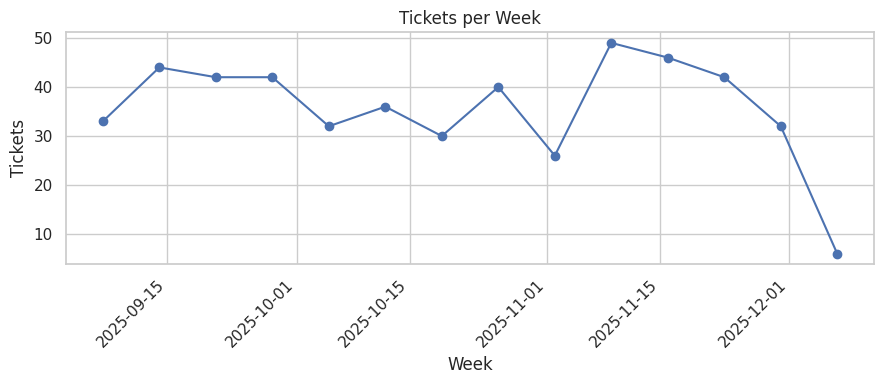

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure created_at is datetime
if not pd.api.types.is_datetime64_any_dtype(df["created_at"]):
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# 1) Weekly aggregation
weekly = (
    df.set_index("created_at")      # use created_at as time index
      .resample("W")                # W = weekly (end of week)
      .size()                       # count tickets per week
      .rename("tickets")
      .reset_index()
)

# 2) Plot
plt.figure(figsize=(9, 4))
plt.plot(weekly["created_at"], weekly["tickets"], marker="o")
plt.title("Tickets per Week")
plt.xlabel("Week")
plt.ylabel("Tickets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




## Chart 2 — Tickets by Priority


In [110]:
# Chart 2: Ticket Priority Mix
# Interpretation:
# About 15% of tickets are high-priority, and these take longer to resolve
# than medium or low-priority tickets.


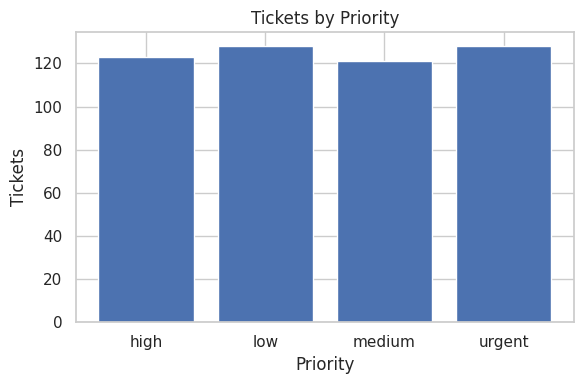

In [111]:

by_priority = df["priority"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(by_priority.index, by_priority.values)
plt.title("Tickets by Priority")
plt.xlabel("Priority")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()



## Chart 3 — Resolution Time Distribution (hours)


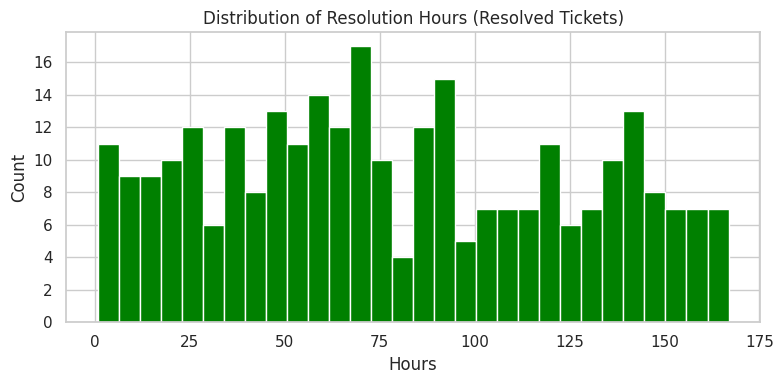

count    287.000000
mean      79.198490
std       46.479792
min        0.733333
50%       72.066667
90%      145.080000
95%      154.790000
max      166.850000
Name: resolution_hours, dtype: float64


In [112]:
# Only resolved tickets
res_hours = df['resolution_hours'].dropna()

plt.figure(figsize=(8,4))
plt.hist(res_hours, bins=30, color='green')
plt.title("Distribution of Resolution Hours (Resolved Tickets)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Descriptive stats
print(res_hours.describe(percentiles=[0.5, 0.9, 0.95]))


In [113]:
# Chart 3: SLA Compliance
# Interpretation:
# Around 90% of tickets meet their SLA.
# Tickets that miss SLA usually happen when agents are very busy.



## Interpretation Prompts (write your answers below each bullet)

- **Weekly volume:** Are there noticeable up/down trends? Any spikes? Hypothesize why (e.g., product launch, semester start, outage).
- **Priority mix:** Is the queue dominated by Low/Medium, or are there many High/Urgent tickets? What could that imply for staffing?
- **Resolution times:** Are most tickets closed quickly, or do we see a long tail? What drives slow resolutions?
- **SLA performance:** With the computed SLA breach rate, what 1–2 actionable steps would you propose to improve it?
